In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
scaler=StandardScaler()


In [30]:
# get the months we need
data = pd.read_csv("/home/marshellon/Downloads/sensor.csv")
data['timestamp'] = pd.to_datetime(data["timestamp"])
apr_may_jun_df = data[(data['timestamp'].dt.month >= 4) & (data['timestamp'].dt.month <= 6)]
apr_may_jun_df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [33]:
# save these for later use
other_months_df = data[(data['timestamp'].dt.month > 4)]
other_months_df = other_months_df.drop(columns=["machine_status"])
other_months_df.to_csv('other_months_data.csv', index=False)

In [13]:
# drop the columns with data missing around 30 procent
to_remove = []
for column in apr_may_jun_df.columns:
    na_per_col = apr_may_jun_df[column].isna().sum() / len(apr_may_jun_df[column]) * 100
    if na_per_col > 30:
        to_remove.append(column)
print(to_remove)



['sensor_15']


In [14]:
def remove_col(data,collumns:list):
    """
    function:
            remove columns from dataframe
    input:
        data = origineel dataframe
        collumns = list of columns to be removed

    return:
            cleaned data  
    """
    for column in collumns:
        data.drop(column,inplace = True,axis =1)
    return data



In [16]:
# drop na from columns
data = remove_col(apr_may_jun_df,to_remove)
# # set timestamp to date
data = data.set_index('timestamp')

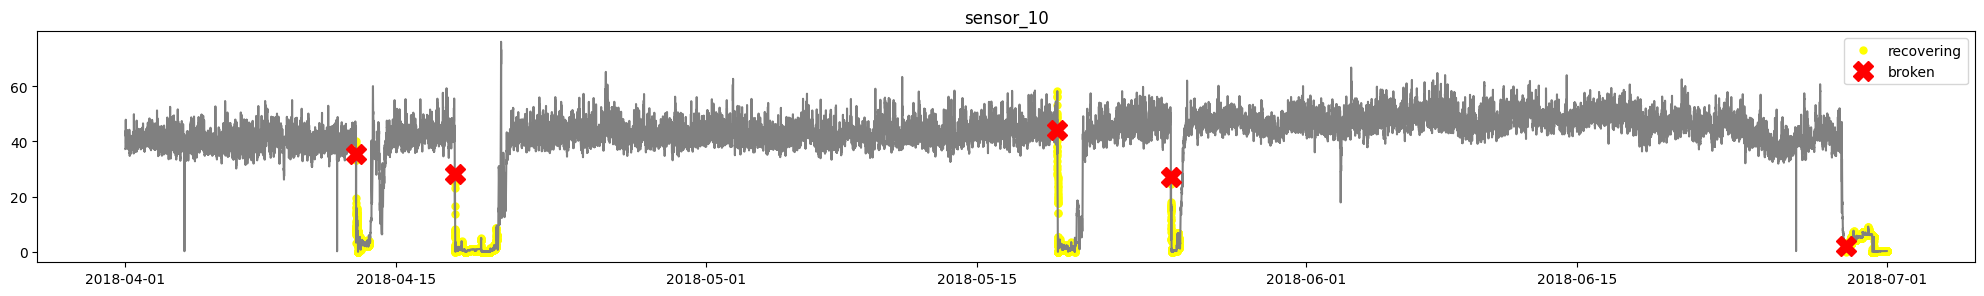

In [17]:
broken_rows = data[data['machine_status']=='BROKEN']
recovery_rows = data[data['machine_status']=='RECOVERING']
normal_rows = data[data['machine_status']=='NORMAL']

def plot_sensor(sensor):
    plot = plt.figure(figsize=(25,3))
    plot = plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color='yellow', markersize=5, label='recovering')
    plot = plt.plot(data[sensor], color='grey')
    plot = plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red', markersize=14, label = 'broken')
    plot = plt.title(sensor)
    plot = plt.legend()
    plt.show()
# plot sensor 10
plot_sensor('sensor_10')

In [18]:
# use mean of the column to handle missing values and remove label in feature matrix X
m, n = data.shape
X = data.iloc[:,:n-1] # ignore machine status columns
X = X.fillna(X.mean())
X.shape

(131040, 52)

In [19]:
X = scaler.fit_transform(X)

In [ ]:
outliers_fraction = 1 - (len(normal_rows)/(len(data))) 

In [20]:
iso = IsolationForest()
iso.fit(X)

IsolationForest()

In [21]:
y_pred = iso.predict(X)

In [23]:
data["prediction"] = y_pred

In [24]:
def plot_sensor_anomolies(sensor):
    anomoly_rows = data[data["prediction"] == -1]
    plot = plt.figure(figsize=(25,3))
    plot = plt.plot(data[sensor], color='grey')
    plot = plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color='yellow', markersize=5, label='recovering',alpha = 0.5)
    plot = plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red', markersize=20, label='broken')
    plot = plt.plot(anomoly_rows[sensor], linestyle='none', marker='X', color='blue', markersize=4, label='anomoly predicted', alpha = 0.1)
    plot = plt.title(sensor)
    plot = plt.legend()
    plt.show();

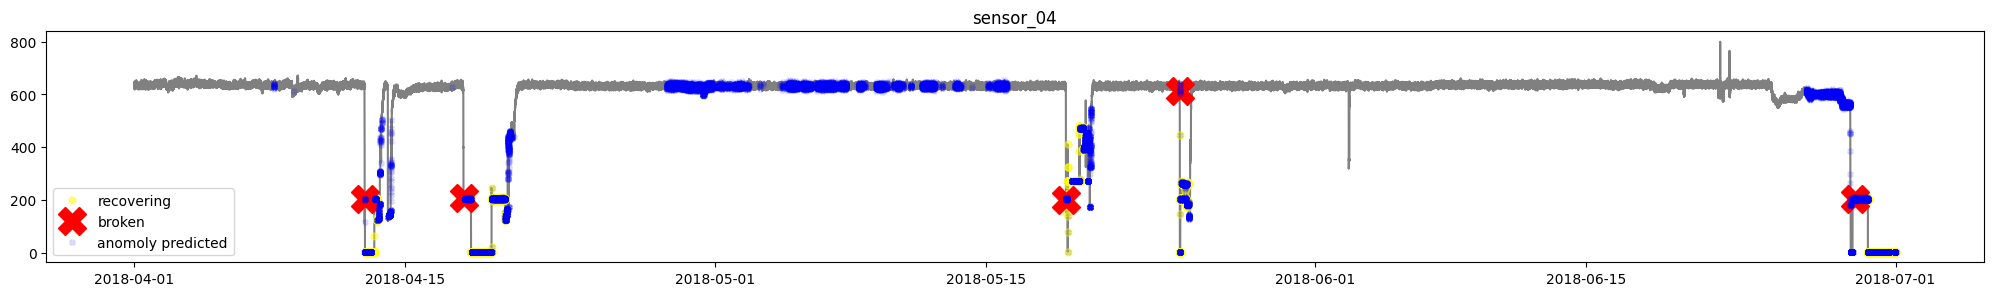

In [26]:
plot_sensor_anomolies('sensor_04')

In [28]:
# pretty good lets save the model and try with an actual script and new data
from joblib import dump
dump(iso, 'model.joblib')

['model.joblib']